In [1]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from kneed import KneeLocator
from scipy.stats import pearsonr

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
base_path = os.path.dirname(os.path.abspath("_file_"))

json_dir = base_path + "/Solutions"

json_pattern = os.path.join(json_dir, '*.json')
file_list = glob.glob(json_pattern)

dfs = []
for file in file_list:
    with open(file) as f:
        data = json.loads(f.read())
        temp_data = {}
        temp_data['Assignments'] = []
        for course in data['Assignments']:
            if '-' in course['Course']:
                courses_list = course['Course'].split('-')
                for i in range(len(courses_list)):
                    temp_dict = {'Course': courses_list[i], 'Events':[course['Events'][i]]}
                    temp_data['Assignments'].append(temp_dict)
            else:
                temp_data['Assignments'].append(course)
        data = temp_data
        json_data = pd.json_normalize(data=data['Assignments'], record_path='Events', meta=['Course'])
    dfs.append(json_data)
df = pd.concat(dfs, ignore_index = True)
df

,Exam,Part,Period,Room,Course
0,0,Oral,27,438,2414
1,0,Oral,32,303,2416
2,0,Oral,25,307,2417
3,0,Oral,19,437,2418
4,0,Oral,33,304,2419
...,...,...,...,...,...
10829,1,Oral,301,482,3674
10830,0,Written,14,471,3733
10831,0,Oral,15,488,3734
10832,1,Written,284,471,3735


In [3]:
df.shape

(10834, 5)

In [4]:
print('There are {} rows and {} columns in our dataset'.format(df.shape[0], df.shape[1]))

There are 10834 rows and 5 columns in our dataset


In [5]:
df.head()

,Exam,Part,Period,Room,Course
0,0,Oral,27,438,2414
1,0,Oral,32,303,2416
2,0,Oral,25,307,2417
3,0,Oral,19,437,2418
4,0,Oral,33,304,2419


In [6]:
df.tail()

,Exam,Part,Period,Room,Course
10829,1,Oral,301,482,3674
10830,0,Written,14,471,3733
10831,0,Oral,15,488,3734
10832,1,Written,284,471,3735
10833,1,Oral,285,483,3736


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Exam    10834 non-null  int64 
 1   Part    10834 non-null  object
 2   Period  10834 non-null  int64 
 3   Room    10587 non-null  object
 4   Course  10834 non-null  object
dtypes: int64(2), object(3)
memory usage: 423.3+ KB


In [8]:
df.describe()

,Exam,Period
count,10834.000000,10834.000000
mean,0.372439,43.088241
std,0.539085,39.130456
min,0.000000,0.000000
25%,0.000000,15.000000
50%,0.000000,34.000000
75%,1.000000,62.000000
max,2.000000,329.000000


In [9]:
duplicated_rows = df.duplicated().sum()
duplicated_rows

0

In [10]:
unique_rooms = len(pd.unique(df['Room']))
unique_rooms

479

In [11]:
unique_periods = len(pd.unique(df['Period']))
unique_periods

230

In [12]:
unique_courses = len(pd.unique(df['Course']))
unique_courses 

10659

In [13]:
df.isnull().sum()

Exam        0
Part        0
Period      0
Room      247
Course      0
dtype: int64

In [14]:
df['Room'] = df['Room'].fillna(df['Room'].mode()[0])

In [15]:
df.isnull().sum()

Exam      0
Part      0
Period    0
Room      0
Course    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Exam    10834 non-null  int64 
 1   Part    10834 non-null  object
 2   Period  10834 non-null  int64 
 3   Room    10834 non-null  object
 4   Course  10834 non-null  object
dtypes: int64(2), object(3)
memory usage: 423.3+ KB


In [17]:
df_converted = df.astype({'Room':'int64', 'Course':'int64'})
df = df_converted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10834 entries, 0 to 10833
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Exam    10834 non-null  int64 
 1   Part    10834 non-null  object
 2   Period  10834 non-null  int64 
 3   Room    10834 non-null  int64 
 4   Course  10834 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 423.3+ KB


In [18]:
df.describe()

,Exam,Period,Room,Course
count,10834.000000,10834.000000,10834.000000,10834.000000
mean,0.372439,43.088241,2657.007753,35759.283275
std,0.539085,39.130456,1324.323441,20276.039664
min,0.000000,0.000000,289.000000,781.000000
25%,0.000000,15.000000,1436.000000,26686.250000
50%,0.000000,34.000000,2639.000000,38133.500000
75%,1.000000,62.000000,3437.000000,46019.750000
max,2.000000,329.000000,5579.000000,81147.000000


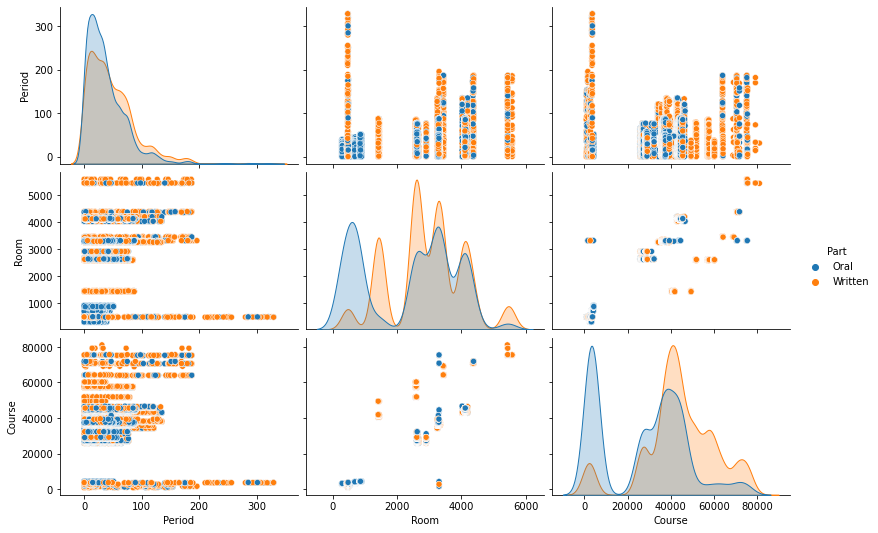

In [19]:
sns.pairplot(df.drop('Exam', axis=1), hue='Part', aspect=1.5)

<AxesSubplot:xlabel='Exam', ylabel='count'>

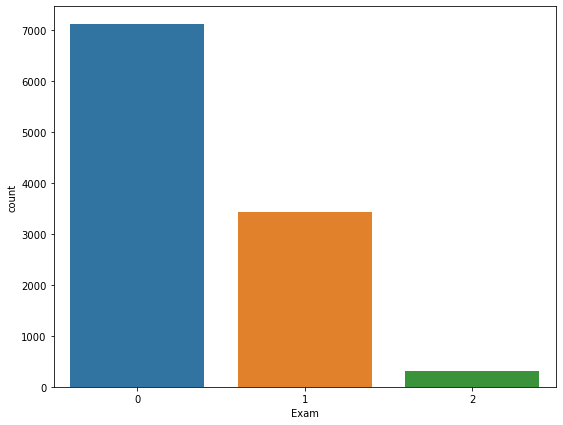

In [20]:
plt.figure(figsize=(9,7))
sns.countplot(x=df['Exam'])

In [21]:
temp_df = df
temp_df['Exam'] = df['Exam'].astype(str)
temp_df['Exam'] = df['Exam'].replace({str(0): 'First', str(1): 'Second', str(2): 'Third'})
temp_df

,Exam,Part,Period,Room,Course
0,First,Oral,27,438,2414
1,First,Oral,32,303,2416
2,First,Oral,25,307,2417
3,First,Oral,19,437,2418
4,First,Oral,33,304,2419
...,...,...,...,...,...
10829,Second,Oral,301,482,3674
10830,First,Written,14,471,3733
10831,First,Oral,15,488,3734
10832,Second,Written,284,471,3735


Text(0, 0.5, 'Courses')

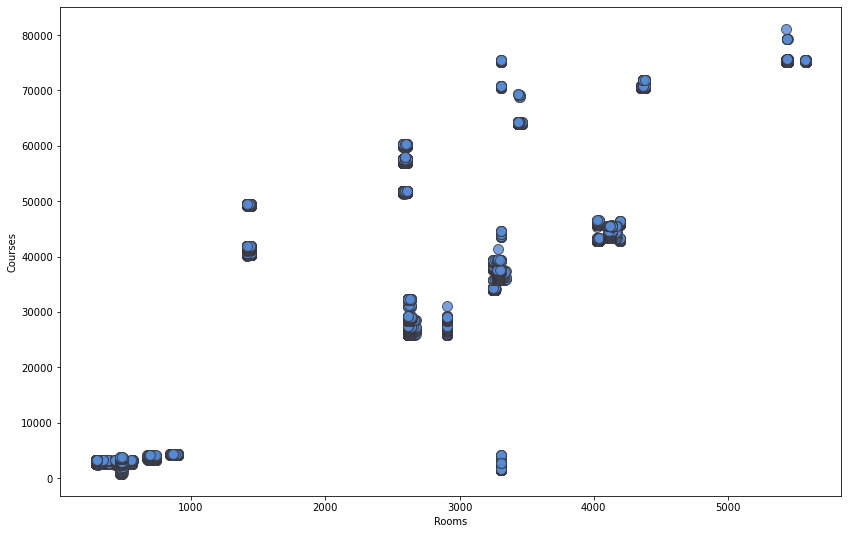

In [22]:
plt.figure(figsize=(14,9))
plt.scatter(df['Room'], df['Course'], c='#568bd6', s=100, edgecolor='#39373d', alpha=0.8)
plt.xlabel('Rooms')
plt.ylabel('Courses')

Text(0, 0.5, 'Courses')

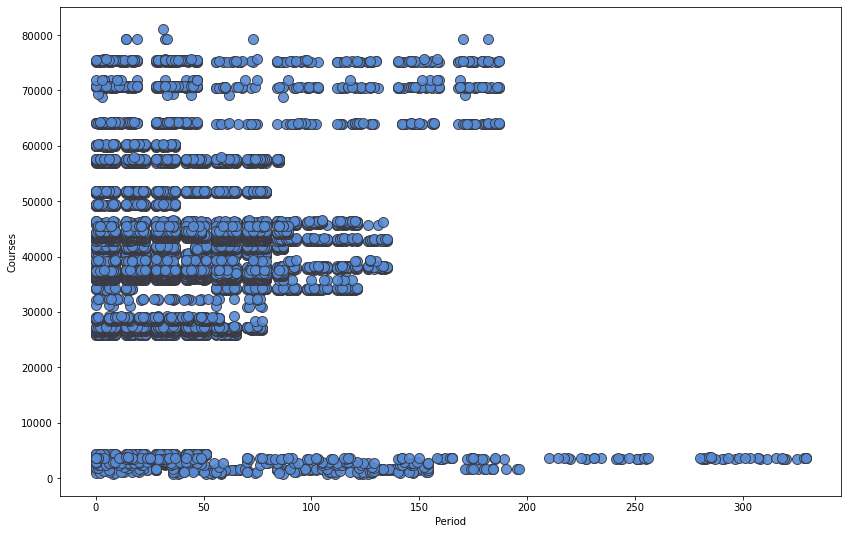

In [23]:
plt.figure(figsize=(14,9))
plt.scatter(df['Period'], df['Course'], c='#568bd6', s=100, edgecolor='#39373d', alpha=0.9)
plt.xlabel('Period')
plt.ylabel('Courses')

Text(0, 0.5, 'Count')

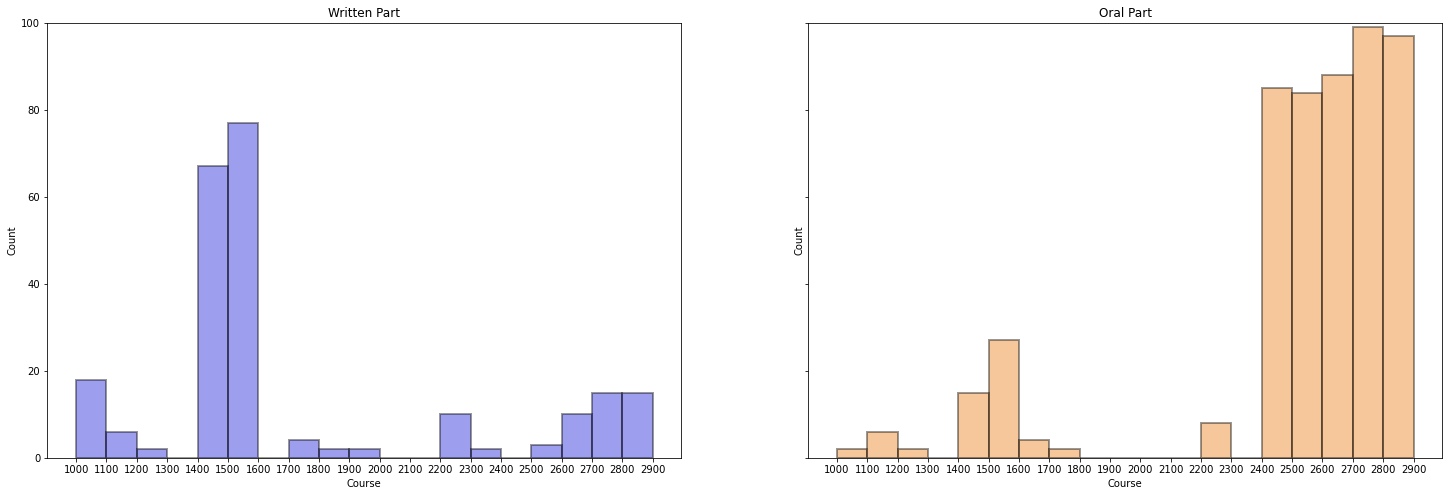

In [24]:
# subset with exam written part
written_part = df[df['Part']=='Written']['Course']
# subset with exam oral part
oral_part = df[df['Part']=='Oral']['Course']

course_bins = range(1000, 3000, 100)

# written part histogram
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8), sharey=True)
sns.distplot(written_part, bins=course_bins, kde=False, color='#0b11d6', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(course_bins)
ax1.set_ylim(top=100)
ax1.set_title('Written Part')
ax1.set_ylabel('Count')
# ax1.text(45,23, "TOTAL count: {}".format(written_part.count()))

# oral part histogram
sns.distplot(oral_part, bins=course_bins, kde=False, color='#e67505', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(course_bins)
ax2.set_title('Oral Part')
ax2.set_ylabel('Count')
# ax2.text(45,23, "TOTAL count: {}".format(oral_part.count()))

(-1.1006911022329333,
 1.1013063240709926,
 -1.1012380357507807,
 1.1000589540833705)

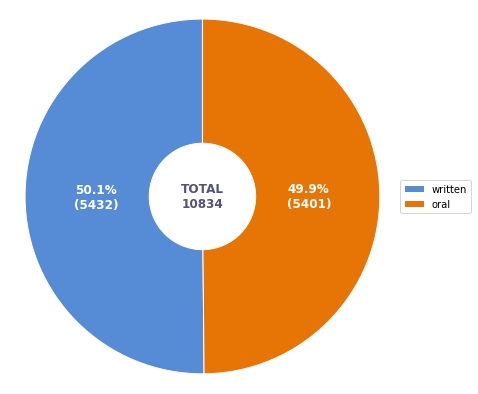

In [25]:
def labeler(pct, values):
    absolute = int(pct/100.*np.sum(values))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [written_part.count(), oral_part.count()]

fig2, ax1 = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#568bd6','#e67505'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['written','oral'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(df['Course'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
#Equal aspect ratio
ax1.axis('equal')

Text(0, 80000, 'Pearson: 0.73')

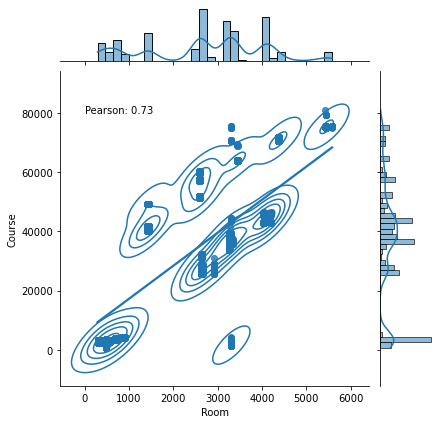

In [26]:
# calculating Pearson's correlation
corr, _ = pearsonr(df_converted['Room'], df_converted['Course'])

jointplot = (sns.jointplot('Room', 'Course', data=df_converted,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,80000, 'Pearson: {:.2f}'.format(corr))